#### Training a Text Classifier

In [1]:
from fastai.text.all import *
path = untar_data(URLs.IMDB)

As we saw at the beginning of this chapter, there are two steps to training a state-of-the-art text classifier using `transfer learning`: first we need to `fine-tune` our language model pretrained on Wikipedia to the corpus of IMDb reviews, and then we can use that model to train a `classifier`.

As usual, let's start with assembling our data.

#### Language Model Using DataBlock

fastai handles tokenization and numericalization automatically when `TextBlock` is passed to `DataBlock`. All of the arguments that can be passed to `Tokenize` and `Numericalize` can also be passed to TextBlock. And don't forget about DataBlock's handy `summary` method, which is very useful for debugging data issues.

Here's how we use `TextBlock` to create a language model, using fastai's defaults:

In [2]:
get_imdb = partial(get_text_files, folders=['train', 'test', 'unsup'])

dls_lm = DataBlock(
    blocks=TextBlock.from_folder(path, is_lm=True),
    get_items=get_imdb, splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

One thing that's different to previous types we've used in `DataBlock` is that we're not just using the class directly i.e., `TextBlock(...)`, but instead are calling a `class method`. A `class method` is a Python method that, as the name suggests, belongs to a class rather than an object. The reason that `TextBlock` is special is that setting up the numericalizer's vocab can take a long time (we have to read and tokenize every document to get the vocab). To be as efficient as possible it performs a few optimizations:

    It saves the tokenized documents in a temporary folder, so it doesn't have to tokenize them more than once
    It runs multiple tokenization processes in parallel, to take advantage of your computer's CPUs

We need to tell `TextBlock` how to access the texts, so that it can do this initial preprocessing—that's what `from_folder` does.

`show_batch` then works in the usual way:

In [4]:
dls_lm.show_batch(max_n=2)

,text,text_
0,"xxbos xxmaj danny xxmaj boyle was not the first person to realise that zombies can run like the xxunk . xxmaj that honour belongs to xxmaj lifeforce , which is , of course , the greatest naked space vampire zombies from xxmaj halley 's xxmaj comet running amok in xxmaj london end - of - the - world movie ever made . xxmaj tobe xxmaj hooper may have made a lot of crap , but for this deliriously demented epic","xxmaj danny xxmaj boyle was not the first person to realise that zombies can run like the xxunk . xxmaj that honour belongs to xxmaj lifeforce , which is , of course , the greatest naked space vampire zombies from xxmaj halley 's xxmaj comet running amok in xxmaj london end - of - the - world movie ever made . xxmaj tobe xxmaj hooper may have made a lot of crap , but for this deliriously demented epic sci"
1,"akyroyd makes xxmaj burns a lovable character . xxmaj we root for him and grow to like him a whole lot during the 98 minute running time . \n\n xxmaj but xxmaj akyroyd is n't alone here . xxmaj he gets strong support from other great comic actors . xxmaj walter xxmaj matthau joins the hilarity as a con artist minister who catches on to xxmaj burns ' secret and commits genteel blackmail . xxmaj charles xxmaj grodin "" slow","makes xxmaj burns a lovable character . xxmaj we root for him and grow to like him a whole lot during the 98 minute running time . \n\n xxmaj but xxmaj akyroyd is n't alone here . xxmaj he gets strong support from other great comic actors . xxmaj walter xxmaj matthau joins the hilarity as a con artist minister who catches on to xxmaj burns ' secret and commits genteel blackmail . xxmaj charles xxmaj grodin "" slow burns"


Now that our data is ready, we can fine-tune the pretrained language model.

#### Fine-Tuning the Language Model

To convert the integer word indices into activations that we can use for our neural network, we will use *embeddings*, just like we did for collaborative filtering and tabular modeling. Then we'll feed those embeddings into a `recurrent neural network (RNN)`, using an architecture called `AWD-LSTM`. As we discussed earlier, the *embeddings* in the pretrained model are merged with *random embeddings* added for words that weren't in the pretraining vocabulary. This is handled automatically inside `language_model_learner`:

In [12]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

The loss function used by default is cross-entropy loss, since we essentially have a classification problem (the different categories being the words in our vocab). The `perplexity` metric used here is often used in NLP for language models: it is the exponential of the loss (i.e., `torch.exp(cross_entropy)`). We also include the accuracy metric, to see how many times our model is right when trying to predict the next word, since cross-entropy (as we've seen) is both hard to interpret, and tells us more about the model's confidence than its accuracy.

Going back to the process diagram from the beginning of this chapter. The first arrow has been completed for us and made available as a pretrained model in fastai, and we've just built the DataLoaders and Learner for the second stage. Now we're ready to fine-tune our language model!

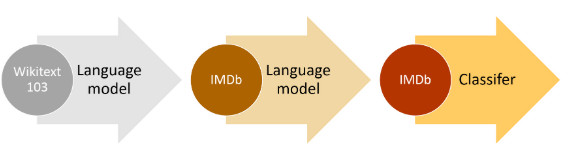

It takes quite a while to train each epoch, so we'll be saving the intermediate model results during the training process. Since `fine_tune` doesn't do that for us, we'll use `fit_one_cycle`. Just like `vision_learner`, `language_model_learner` automatically calls `freeze` when using a pretrained model (which is the default), so this will only train the embeddings (the only part of the model that contains randomly initialized weights—i.e., embeddings for words that are in our IMDb vocab, but aren't in the pretrained model vocab):

In [ ]:
# don't run this cell if you don't have a 8GB GPU
learn.fit_one_cycle(1, 2e-2)

This model takes a while to train, so it's a good opportunity to talk about saving intermediary results.

#### Saving and Loading Models

In [ ]:
learn.save('1epoch')

If you want to load your model in another machine after creating your Learner the same way, or resume training later, you can load the content of this file with:

In [ ]:
learn = learn.load('1epoch')

Once the initial training has completed, we can continue fine-tuning the model after *unfreezing*:

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 2e-3)

Once this is done, we save all of our model except the final layer that converts activations to probabilities of picking each token in our vocabulary. The model not including the final layer is called the `encoder`. We can save it with `save_encoder`:

In [ ]:
learn.save_encoder('finetuned')

This completes the second stage of the text classification process: fine-tuning the language model. We can now use it to fine-tune a classifier using the IMDb sentiment labels.

#### Text Generation

Since it's trained to guess what the next word of the sentence is, we can use the model to write new reviews:

In [ ]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [ ]:
print("\n".join(preds))

As you can see, we add some randomness (we pick a random word based on the probabilities returned by the model) so we don't get exactly the same review twice. If you read carefully that you can notice something is a bit off. Not bad for a model trained in a couple of hours!

But our end goal wasn't to train a model to generate reviews, but to classify them... so let's use this model to do just that.

#### Creating the Classifier DataLoaders

We're now moving from language *model fine-tuning* to *classifier fine-tuning*. To recap, a language model predicts the next word of a document, so it doesn't need any external labels. A `classifier`, however, *predicts* some external label—in the case of IMDb, it's the sentiment of a document.

This means that the structure of our `DataBlock` for NLP classification will look very familiar. It's actually nearly the same as we've seen for the many image classification datasets we've worked with:

In [ ]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_folder(path, vocab=dls_lm.vocab),CategoryBlock),
    get_y = parent_label,
    get_items=partial(get_text_files, folders=['train', 'test']),
    splitter=GrandparentSplitter(valid_name='test')
).dataloaders(path, path=path, bs=128, seq_len=72)

Just like with image classification, `show_batch` shows the `dependent variable` (sentiment, in this case) with each `independent variable` (movie review text):

In [ ]:
dls_clas.show_batch(max_n=3)

Looking at the `DataBlock` definition, every piece is familiar from previous data blocks we've built, with two important exceptions:

    1. `TextBlock.from_folder` no longer has the `is_lm=True` parameter.
    2. We pass the `vocab` we created for the language model fine-tuning.

The reason that we pass the `vocab` of the language model is to make sure we use the same correspondence of token to index. Otherwise the `embeddings` we learned in our fine-tuned language model won't make any sense to this model, and the fine-tuning step won't be of any use.

By passing `is_lm=False` (or not passing `is_lm` at all, since it defaults to `False`) we tell `TextBlock` that we have regular labeled data, rather than using the next tokens as labels. There is one challenge we have to deal with, however, which is to do with collating multiple documents into a mini-batch. Let's see with an example, by trying to create a mini-batch containing the first 10 documents. First we'll numericalize them:

In [ ]:
nums_samp = toks200[:10].map(num)

Let's now look at how many tokens each of these 10 movie reviews have:

In [ ]:
nums_samp.map(len)

Remember, PyTorch `DataLoader`s need to collate all the items in a batch into a single tensor, and a single tensor has a fixed shape (i.e., it has some particular length on every axis, and all items must be consistent). This should sound familiar: we had the same issue with images. In that case, we used cropping, padding, and/or squishing to make all the inputs the same size. Cropping might not be a good idea for documents, because it seems likely we'd remove some key information (having said that, the same issue is true for images, and we use cropping there; data augmentation hasn't been well explored for NLP yet). You can't really "squish" a document. So that leaves padding!

We will expand the shortest texts to make them all the same size. To do this, we use a *special padding token* that will be ignored by our model. Additionally, to avoid memory issues and improve performance, we will batch together texts that are roughly the same lengths (with some shuffling for the training set). We do this by (approximately, for the training set) sorting the documents by length prior to each epoch. The result of this is that the documents collated into a single batch will tend to be of similar lengths. We won't pad every batch to the same size, but will instead use the size of the largest document in each batch as the target size. (It is possible to do something similar with images, which is especially useful for irregularly sized rectangular images, but at the time of writing no library provides good support for this yet)

The sorting and padding are automatically done by the data block API for us when using a `TextBlock`, with `is_lm=False`. (We don't have this same issue for language model data, since we concatenate all the documents together first, and then split them into equally sized sections.)

We can now create a model to classify our texts:

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

The final step prior to training the classifier is to load the encoder from our fine-tuned language model. We use `load_encoder` instead of `load` because we only have pretrained weights available for the encoder; `load` by default raises an exception if an incomplete model is loaded:

In [ ]:
learn = learn.load_encoder('finetuned')

#### Fine-Tuning the Classifier

The last step is to train with discriminative *learning rates* and *gradual unfreezing*. In computer vision we often `unfreeze` the model all at once, but for NLP classifiers, we find that unfreezing a few layers at a time makes a real difference:

In [ ]:
learn.fit_one_cycle(1, 2e-2)

In just one epoch we get the same result as our training in <<chapter_intro>>: not too bad! We can pass `-2` to `freeze_to` to freeze all except the last two parameter groups:

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

Then we can unfreeze a bit more, and continue training:

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

And finally, the whole model!

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

We reached 94.3% accuracy, which was state-of-the-art performance just three years ago. By training another model on all the texts read backwards and averaging the predictions of those two models, we can even get to 95.1% accuracy, which was the state of the art introduced by the ULMFiT paper. It was only beaten a few months ago, by fine-tuning a much bigger model and using expensive data augmentation techniques (translating sentences in another language and back, using another model for translation).